<a href="https://colab.research.google.com/github/nisha876/Predicting-User-Churn-for-an-E-commerce-Platform/blob/main/events_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing libraries
# Data Handling and Manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Uncomment below if using interactive visualizations
# import plotly.express as px
# import altair as alt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE  # For handling class imbalance

# Feature Engineering
from category_encoders import OneHotEncoder  # For categorical feature encoding

# Model Interpretability
import shap
# Uncomment below if using LIME
# from lime.lime_tabular import LimeTabularExplainer

# Performance Optimization
from joblib import dump, load
from tqdm import tqdm  # For progress tracking

# Jupyter Notebook Utilities (Optional)
# Uncomment if working within a notebook
# %matplotlib inline


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/hizen.ai - ML -Assignment/events.csv')

# Check basic information about the dataset
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB
None


In [ ]:
# Display the first few rows to inspect the data
print(data.head(5))

In [ ]:
# Check for missing values
print(data.isnull().sum())

# data inspection

In [ ]:
data['event_time'] = pd.to_datetime(data['event_time'])
data['event_time']

,event_time
0,2020-09-24 11:57:06+00:00
1,2020-09-24 11:57:26+00:00
2,2020-09-24 11:57:27+00:00
3,2020-09-24 11:57:33+00:00
4,2020-09-24 11:57:36+00:00
...,...
885124,2021-02-28 23:55:01+00:00
885125,2021-02-28 23:58:05+00:00
885126,2021-02-28 23:58:09+00:00
885127,2021-02-28 23:58:14+00:00


In [ ]:
print(data['event_type'].value_counts())
print(data['brand'].nunique())
print(data['category_code'].nunique())


event_type
view        793748
cart         54035
purchase     37346
Name: count, dtype: int64
999
107


In [ ]:
print(data.describe)

<bound method NDFrame.describe of                       event_time event_type  product_id          category_id  \
0      2020-09-24 11:57:06+00:00       view     1996170  2144415922528452715   
1      2020-09-24 11:57:26+00:00       view      139905  2144415926932472027   
2      2020-09-24 11:57:27+00:00       view      215454  2144415927158964449   
3      2020-09-24 11:57:33+00:00       view      635807  2144415923107266682   
4      2020-09-24 11:57:36+00:00       view     3658723  2144415921169498184   
...                          ...        ...         ...                  ...   
885124 2021-02-28 23:55:01+00:00       view      953226  2144415927553229037   
885125 2021-02-28 23:58:05+00:00       view     1715907  2144415927049912542   
885126 2021-02-28 23:58:09+00:00       view     4170534  2144415939364389423   
885127 2021-02-28 23:58:14+00:00       view      888273  2144415921932861531   
885128 2021-02-28 23:59:09+00:00       view      743182  2144415935631458761   

     

In [ ]:
print(f"Unique users: {data['user_id'].nunique()}")
print(f"Unique sessions: {data['user_session'].nunique()}")

Unique users: 407283
Unique sessions: 490398


# Data Cleaning

In [ ]:
#handling missing values
missing_columns = data.columns[data.isnull().any()]
print(data[missing_columns].isnull().sum())

category_code    236219
brand            212364
user_session        165
dtype: int64


In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
# Sort data by user_session and event_time
data = data.sort_values(by=['user_session', 'event_time'])

# Check the sequence of events for a sample session
sample_session = data[data['user_session'] == data['user_session'].iloc[0]]
print(sample_session[['event_time', 'event_type', 'product_id']])


                      event_time event_type  product_id
717617 2021-01-31 20:27:14+00:00       view      337112


In [ ]:
# Aggregate event types for each session into a single sequence
session_event_sequences = data.groupby('user_session')['event_type'].apply(lambda x: ''.join(x))

# Define the function to check for invalid sequences
def check_event_sequence(sequence):
    # Valid sequences must include "cartpurchase" or "viewcartpurchase"
    return 'cartpurchase' in sequence or 'viewcartpurchase' in sequence

# Identify invalid sessions
invalid_sessions = session_event_sequences[~session_event_sequences.apply(check_event_sequence)].index

# Display invalid sessions
print(f"Number of invalid sessions: {len(invalid_sessions)}")


Number of invalid sessions: 471655


In [ ]:
# Check sessions with purchases but no cart
sessions_with_purchase = data[data['event_type'] == 'purchase']['user_session'].unique()
sessions_with_cart = data[data['event_type'] == 'cart']['user_session'].unique()

missing_cart_sessions = set(sessions_with_purchase) - set(sessions_with_cart)
print(f"Sessions with purchases but no cart: {len(missing_cart_sessions)}")


Sessions with purchases but no cart: 3582


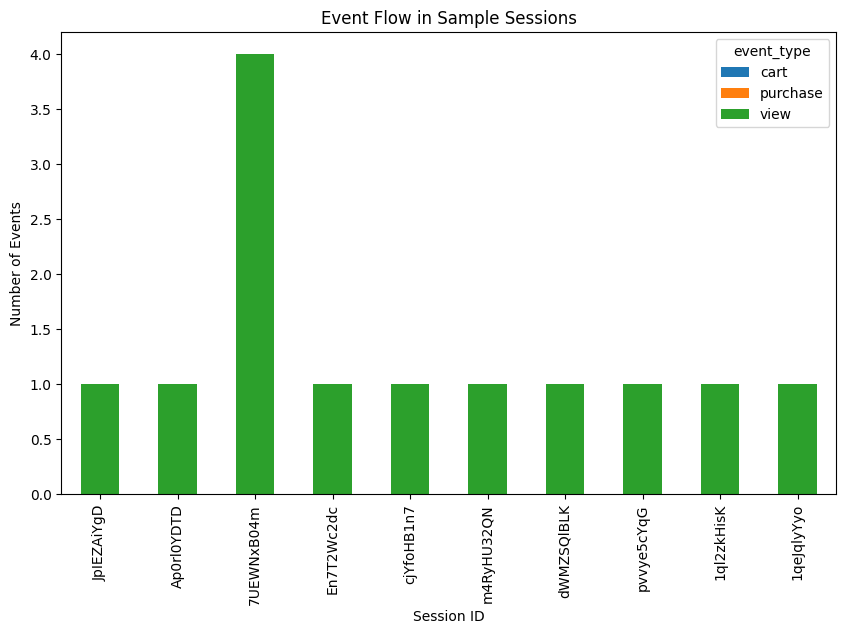

In [ ]:

# Count events per session
event_flow = data.groupby(['user_session', 'event_type']).size().unstack().fillna(0)

# Visualize flow for a sample of sessions
event_flow.sample(10).plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Event Flow in Sample Sessions')
plt.xlabel('Session ID')
plt.ylabel('Number of Events')
plt.show()


In [ ]:
# Filter out invalid sessions (if necessary)
valid_data = data[~data['user_session'].isin(invalid_sessions)]

print(f"Original Data Size: {data.shape}")
print(f"Valid Data Size After Cleaning: {valid_data.shape}")


Original Data Size: (884474, 9)
Valid Data Size After Cleaning: (119772, 9)


#EDA(Exploratory Data Analysis

In [ ]:
# step 1 absic information of dataset
# Display the first few rows
print(data.head())

# Summary of dataset
print(data.info())

# Check for missing values
print(data.isnull().sum())

# Check for duplicates
print(f"Duplicate rows: {data.duplicated().sum()}")


                      event_time event_type  product_id          category_id  \
717617 2021-01-31 20:27:14+00:00       view      337112  2144415921505042512   
27197  2020-09-30 17:52:02+00:00       view     1675002  2144415922872385653   
577627 2021-01-09 23:35:49+00:00       view       40146  2144415925732901052   
221736 2020-11-06 01:25:30+00:00       view     3605162  2144415924684325027   
221737 2020-11-06 01:25:43+00:00       view     3585175  2144415924684325027   

                      category_code    brand   price              user_id  \
717617                          NaN      NaN   12.06  1515915625599214495   
27197            electronics.tablet   xiaomi  421.22  1515915625509232600   
577627    appliances.kitchen.juicer      NaN   61.98  1515915625591270059   
221736  electronics.audio.headphone      NaN   18.86  1515915625536141302   
221737  electronics.audio.headphone  samsung  148.84  1515915625536141302   

                                user_session  
717617   

<ipython-input-18-697de30bfa98>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='event_type', data=data, order=event_counts.index, palette='viridis')


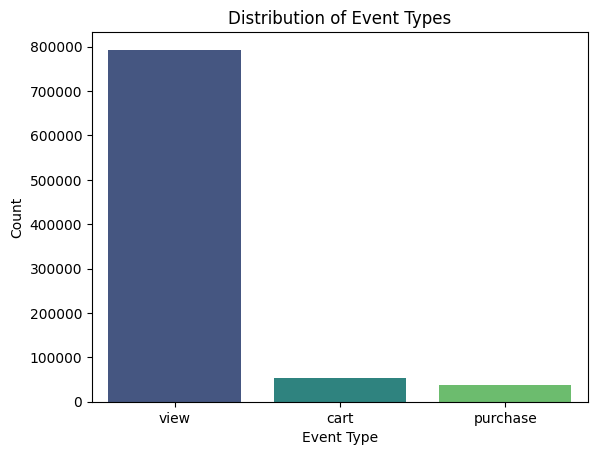

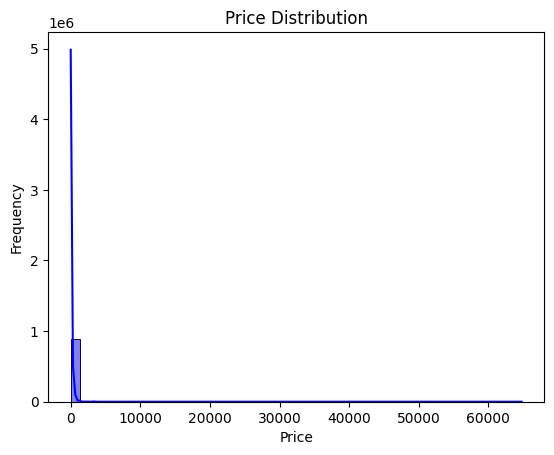

In [ ]:
#step 2 data distribution
# Count the number of each event type
event_counts = data['event_type'].value_counts()

# Plot the distribution
sns.countplot(x='event_type', data=data, order=event_counts.index, palette='viridis')
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()
# Plot the price distribution
sns.histplot(data['price'], kde=True, bins=50, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


Number of unique users: 407283
Number of unique sessions: 490398
Average events per user: 2.1716447777098478


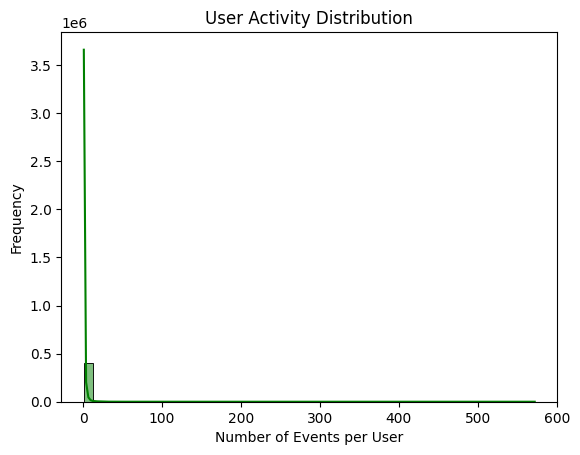

In [ ]:
# session and user analysis
# Number of unique users and sessions
unique_users = data['user_id'].nunique()
unique_sessions = data['user_session'].nunique()

print(f"Number of unique users: {unique_users}")
print(f"Number of unique sessions: {unique_sessions}")

#user activity
# Average events per user
events_per_user = data.groupby('user_id')['event_type'].count()
print(f"Average events per user: {events_per_user.mean()}")

# Plot distribution of user activity
sns.histplot(events_per_user, bins=50, kde=True, color='green')
plt.title('User Activity Distribution')
plt.xlabel('Number of Events per User')
plt.ylabel('Frequency')
plt.show()



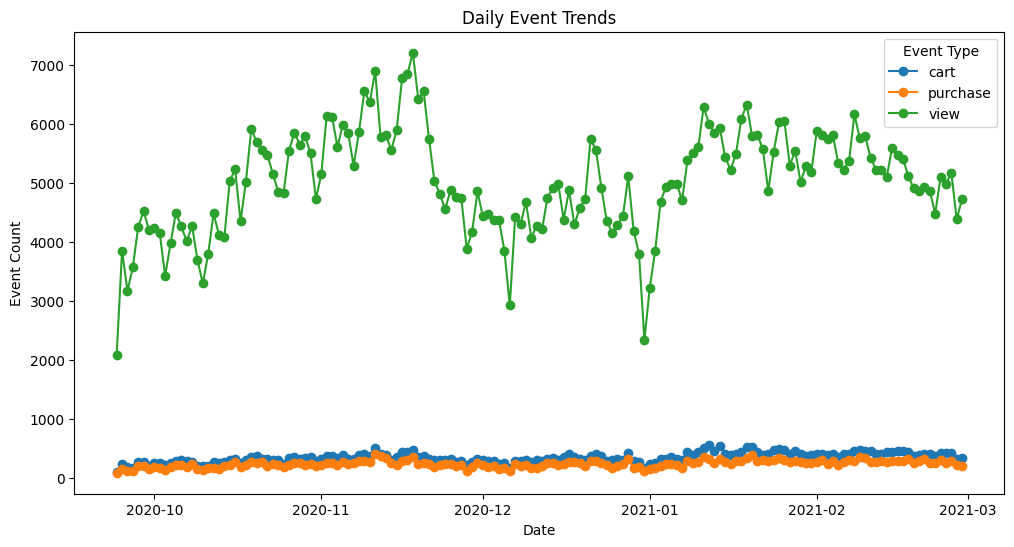

In [ ]:
#step 4 Temporal Analysis
#events over a time
# Extract date and time
data['date'] = data['event_time'].dt.date

# Daily event counts
daily_events = data.groupby('date')['event_type'].value_counts().unstack()

# Plot daily trends
daily_events.plot(figsize=(12, 6), marker='o')
plt.title('Daily Event Trends')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.legend(title='Event Type')
plt.show()


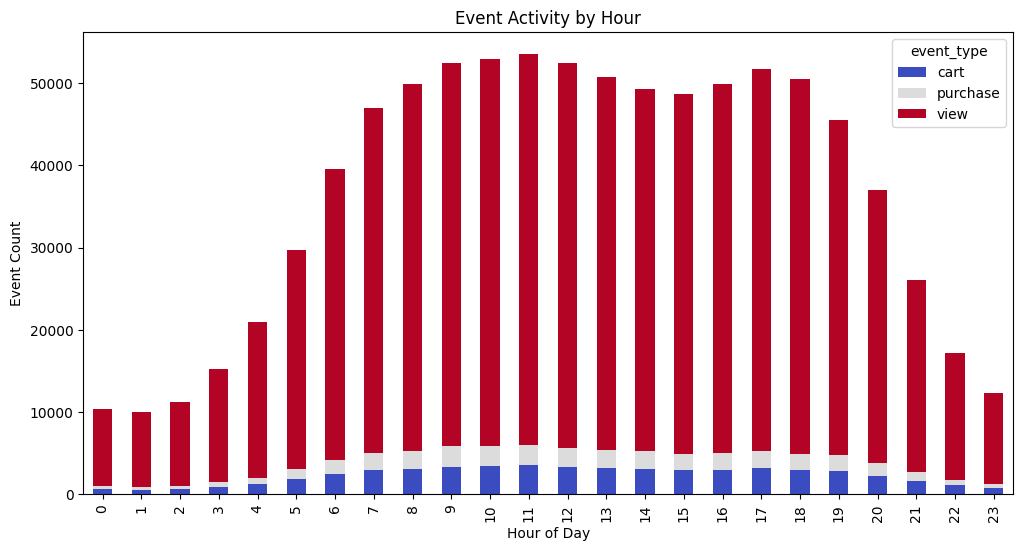

In [ ]:
#peak time for events
# Extract hour from the event time
data['hour'] = data['event_time'].dt.hour

# Count events by hour
hourly_events = data.groupby('hour')['event_type'].value_counts().unstack()

# Plot event activity by hour
hourly_events.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title('Event Activity by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Event Count')
plt.show()


Top 10 Most Viewed Products:
product_id
1821813    12794
3791351     5717
4099645     5489
1785245     4630
3829355     4552
809948      3830
1830099     3660
3791509     3150
4154414     3000
893196      2865
Name: count, dtype: int64
Top 10 Categories:
category_code
computers.components.videocards     116611
electronics.telephone                84308
computers.peripherals.printer        43193
stationery.cartrige                  38699
electronics.audio.acoustic           26749
computers.components.motherboard     26585
computers.notebook                   25024
computers.components.cpu             24750
electronics.video.tv                 21373
electronics.tablet                   19373
Name: count, dtype: int64


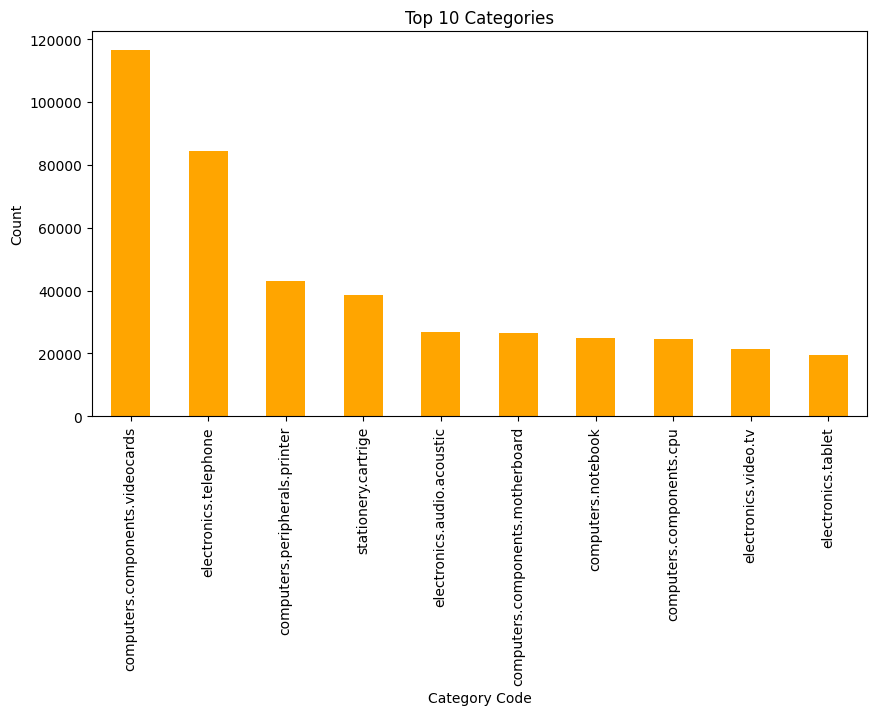

In [ ]:
#step5 Product and category Analysis
# Top 10 most viewed products
top_products = data[data['event_type'] == 'view']['product_id'].value_counts().head(10)
print("Top 10 Most Viewed Products:")
print(top_products)

# Top 10 categories
top_categories = data['category_code'].value_counts().head(10)
print("Top 10 Categories:")
print(top_categories)

# Plot top categories
top_categories.plot(kind='bar', color='orange', figsize=(10, 5))
plt.title('Top 10 Categories')
plt.xlabel('Category Code')
plt.ylabel('Count')
plt.show()


Top Brands:
brand
asus         27660
gigabyte     27652
msi          24864
palit        24787
samsung      23188
amd          20095
canon        18430
panasonic    11977
pioneer      11463
sirius       11406
Name: count, dtype: int64


<ipython-input-23-fc623b005e92>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_brands.values, y=top_brands.index, palette='mako')


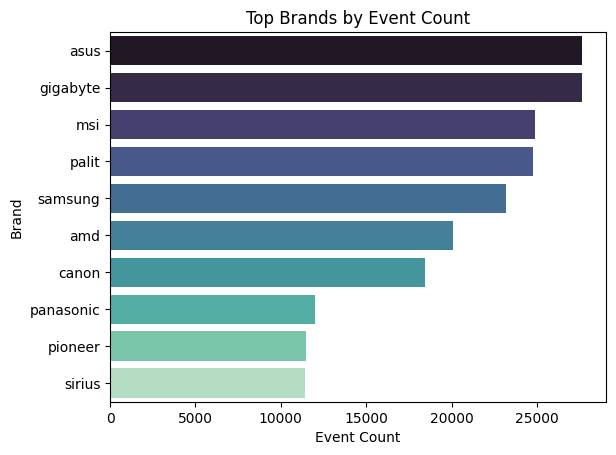

In [ ]:
#brand analysis
# Top brands by number of events
top_brands = data['brand'].value_counts().head(10)
print("Top Brands:")
print(top_brands)

# Plot top brands
sns.barplot(x=top_brands.values, y=top_brands.index, palette='mako')
plt.title('Top Brands by Event Count')
plt.xlabel('Event Count')
plt.ylabel('Brand')
plt.show()


In [ ]:
#step 6 behavorial analysis
#view to cart and cart to puchase ratios
# Calculate number of events per user
user_events = data.groupby('user_id')['event_type'].value_counts().unstack().fillna(0)

# Add new columns for ratios
user_events['view_to_cart_ratio'] = user_events['cart'] / user_events['view']
user_events['cart_to_purchase_ratio'] = user_events['purchase'] / user_events['cart']

# Replace NaN or inf with 0
user_events.fillna(0, inplace=True)

# Summary of ratios
print(user_events[['view_to_cart_ratio', 'cart_to_purchase_ratio']].describe())


event_type  view_to_cart_ratio  cart_to_purchase_ratio
count                 407283.0                407283.0
mean                       inf                     inf
std                        NaN                     NaN
min                        0.0                     0.0
25%                        0.0                     0.0
50%                        0.0                     0.0
75%                        0.0                     0.0
max                        inf                     inf


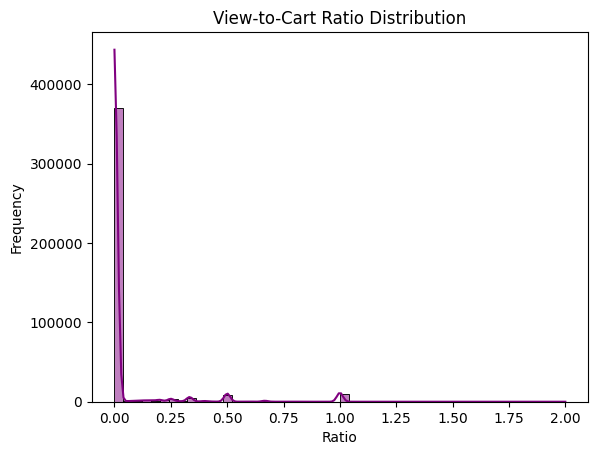

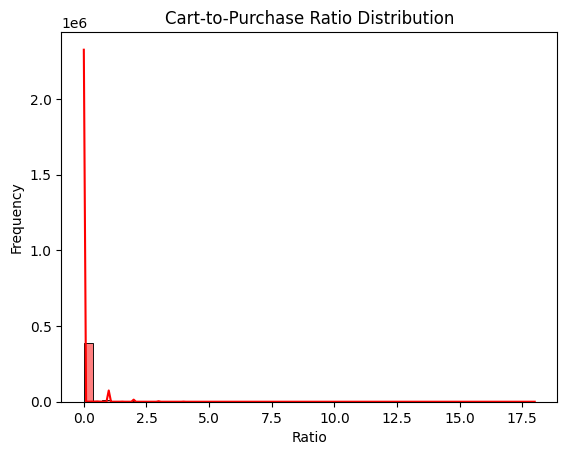

In [ ]:
# Plot view-to-cart and cart-to-purchase ratios
sns.histplot(user_events['view_to_cart_ratio'], kde=True, bins=50, color='purple')
plt.title('View-to-Cart Ratio Distribution')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.show()

sns.histplot(user_events['cart_to_purchase_ratio'], kde=True, bins=50, color='red')
plt.title('Cart-to-Purchase Ratio Distribution')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.show()


#Churn is defined as a user who has not made a purchase or interacted (viewed or carted a product) within the last 30 days.

In [ ]:
#calculating recency for each user
# Convert event_time to datetime if not already
data['event_time'] = pd.to_datetime(data['event_time'])

# Get the most recent event date in the dataset
last_event_date = data['event_time'].max()

# Calculate recency for each user
user_last_activity = data.groupby('user_id')['event_time'].max()
user_last_activity = pd.DataFrame(user_last_activity).reset_index()
user_last_activity['days_since_last_event'] = (last_event_date - user_last_activity['event_time']).dt.days

# Display sample
print(user_last_activity.head())


               user_id                event_time  days_since_last_event
0  1515915625353226922 2020-10-29 11:28:35+00:00                    122
1  1515915625353230067 2020-10-06 06:30:32+00:00                    145
2  1515915625353230683 2020-12-12 10:33:09+00:00                     78
3  1515915625353230922 2020-10-02 08:23:40+00:00                    149
4  1515915625353234047 2021-02-18 09:11:44+00:00                     10


In [ ]:
# Define a churn threshold (e.g., 30 days)
churn_threshold = 30

# Add churn label: 1 for churned, 0 for active
user_last_activity['is_churned'] = (user_last_activity['days_since_last_event'] > churn_threshold).astype(int)

# Display churn statistics
print(user_last_activity['is_churned'].value_counts())


is_churned
1    325360
0     81923
Name: count, dtype: int64


In [ ]:
user_summary = data.groupby('user_id').agg(
    total_views=('event_type', lambda x: (x == 'view').sum()),
    total_carts=('event_type', lambda x: (x == 'cart').sum()),
    total_purchases=('event_type', lambda x: (x == 'purchase').sum())
)

user_summary.head()


,total_views,total_carts,total_purchases
user_id,,,
1515915625353226922,1,0,0
1515915625353230067,1,0,0
1515915625353230683,13,0,0
1515915625353230922,1,0,0
1515915625353234047,36,0,0


# Feature Engineering

In [ ]:
# Convert event_time to timezone-naive (remove timezone info)
data['event_time'] = data['event_time'].dt.tz_localize(None)


In [ ]:
# Calculate recency: number of days since the last event (purchase or view)
user_last_event = data.groupby('user_id')['event_time'].max()

# Recency: Time since last event in days
user_summary['recency'] = (pd.to_datetime('today') - user_last_event).dt.days



In [ ]:
# Frequency: Total number of events per user
user_summary['frequency'] = data.groupby('user_id').size()


In [ ]:
# Monetary: Total money spent by user (only for purchase events)
user_summary['monetary'] = data[data['event_type'] == 'purchase'].groupby('user_id')['price'].sum()


In [ ]:
#behavioral features
# View-to-Cart Ratio: Ratio of views to carts
user_summary['view_to_cart_ratio'] = user_summary['total_views'] / (user_summary['total_carts'] + 1)


In [ ]:
# Cart-to-Purchase Ratio: Ratio of carts to purchases
user_summary['cart_to_purchase_ratio'] = user_summary['total_carts'] / (user_summary['total_purchases'] + 1)


In [ ]:
#session based metrics
# Session count: Total number of sessions for a user
session_count = data.groupby('user_id')['user_session'].nunique()
user_summary['session_count'] = session_count


In [ ]:
# Calculate session duration: First and last event time per session
session_time = data.groupby(['user_id', 'user_session'])['event_time'].agg(['min', 'max'])

# Calculate the duration of each session (in minutes)
session_time['session_duration'] = (session_time['max'] - session_time['min']).dt.total_seconds() / 60

# Calculate average session duration per user
user_summary['avg_session_duration'] = session_time.groupby('user_id')['session_duration'].mean()


In [ ]:
# Calculate bounce rate: Proportion of sessions with only one event
session_count_one_event = data.groupby('user_session').size()
bounce_sessions = session_count_one_event[session_count_one_event == 1].index
bounce_rate = data[data['user_session'].isin(bounce_sessions)].groupby('user_id').size() / session_count

user_summary['bounce_rate'] = bounce_rate


In [ ]:
#handling categorical values
# Perform one-hot encoding on categorical features like 'category_id' and 'brand' before aggregation
data_encoded = pd.get_dummies(data, columns=['category_id', 'brand'], drop_first=True)

# Now, proceed with the rest of the transformations
user_summary = data_encoded.groupby('user_id').agg(
    total_views=('event_type', lambda x: (x == 'view').sum()),
    total_carts=('event_type', lambda x: (x == 'cart').sum()),
    total_purchases=('event_type', lambda x: (x == 'purchase').sum()),
    # Aggregate other features
    recency=('event_time', 'max'),
    frequency=('event_type', 'count'),
    monetary=('price', 'sum')
)

# Calculate Recency: Time since last event (purchase or view)
user_summary['recency'] = (pd.to_datetime('today') - user_summary['recency']).dt.days

# Further feature engineering (like view_to_cart_ratio, cart_to_purchase_ratio, etc.) goes here...


In [ ]:
#feature scaling
from sklearn.preprocessing import StandardScaler

# Select numerical features for scaling
numerical_features = ['recency', 'frequency', 'monetary', 'view_to_cart_ratio', 'cart_to_purchase_ratio', 'avg_session_duration', 'bounce_rate']

scaler = StandardScaler()
user_summary[numerical_features] = scaler.fit_transform(user_summary[numerical_features])


In [ ]:
# Check the columns of the user_summary dataframe to verify 'churned' exists
print(user_summary.columns)



Index(['total_views', 'total_carts', 'total_purchases', 'recency', 'frequency',
       'monetary'],
      dtype='object')


In [ ]:
# Define churned users as those who have not made a purchase in the last 30 days
last_purchase = data[data['event_type'] == 'purchase'].groupby('user_id')['event_time'].max()

# Set churn condition: no purchase in the last 30 days
churn_threshold = pd.to_datetime('today') - pd.Timedelta(days=30)
churned_users = last_purchase[last_purchase < churn_threshold].index

# Add the 'churned' column to user_summary
user_summary['churned'] = user_summary.index.isin(churned_users).astype(int)


In [ ]:
print(user_summary.head())


                     total_views  total_carts  total_purchases  recency  \
user_id                                                                   
1515915625353226922            1            0                0     1529   
1515915625353230067            1            0                0     1553   
1515915625353230683           13            0                0     1485   
1515915625353230922            1            0                0     1556   
1515915625353234047           36            0                0     1417   

                     frequency  monetary  churned  
user_id                                            
1515915625353226922          1     76.48        0  
1515915625353230067          1     28.98        0  
1515915625353230683         13    814.93        0  
1515915625353230922          1    274.40        0  
1515915625353234047         36   5481.90        0  


#Model training

In [ ]:
# Final feature set (X) and target (y)
X = user_summary.drop(columns=['churned'])
y = user_summary['churned']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
# Evaluate accuracy for Logistic Regression
accuracy_log_reg = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy_log_reg}")

# Evaluate Precision, Recall, and F1-Score for Logistic Regression
precision_log_reg = precision_score(y_test, y_pred)
recall_log_reg = recall_score(y_test, y_pred)
f1_log_reg = f1_score(y_test, y_pred)

print(f"Logistic Regression Precision: {precision_log_reg}")
print(f"Logistic Regression Recall: {recall_log_reg}")
print(f"Logistic Regression F1-Score: {f1_log_reg}")

# Evaluate AUC for Logistic Regression
roc_auc_log_reg = roc_auc_score(y_test, y_pred)
print(f"Logistic Regression AUC: {roc_auc_log_reg}")

# Confusion matrix for Logistic Regression
cm_log_reg = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix for Logistic Regression:\n{cm_log_reg}")

Logistic Regression Accuracy: 1.0
Logistic Regression Precision: 1.0
Logistic Regression Recall: 1.0
Logistic Regression F1-Score: 1.0
Logistic Regression AUC: 1.0
Confusion Matrix for Logistic Regression:
[[115885      0]
 [     0   6300]]


In [ ]:
from sklearn.metrics import classification_report

# Classification report for Logistic Regression
class_report_log_reg = classification_report(y_test, y_pred)
print(f"Classification Report for Logistic Regression:\n{class_report_log_reg}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    115885
           1       1.00      1.00      1.00      6300

    accuracy                           1.00    122185
   macro avg       1.00      1.00      1.00    122185
weighted avg       1.00      1.00      1.00    122185



In [ ]:
from sklearn.ensemble import RandomForestClassifier


# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred_rf)
auc = roc_auc_score(y_test, y_pred_rf)
classification_rep = classification_report(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")
print(f"Classification Report:\n{classification_rep}")
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 1.0
AUC: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    115885
           1       1.00      1.00      1.00      6300

    accuracy                           1.00    122185
   macro avg       1.00      1.00      1.00    122185
weighted avg       1.00      1.00      1.00    122185

Confusion Matrix:
[[115885      0]
 [     0   6300]]


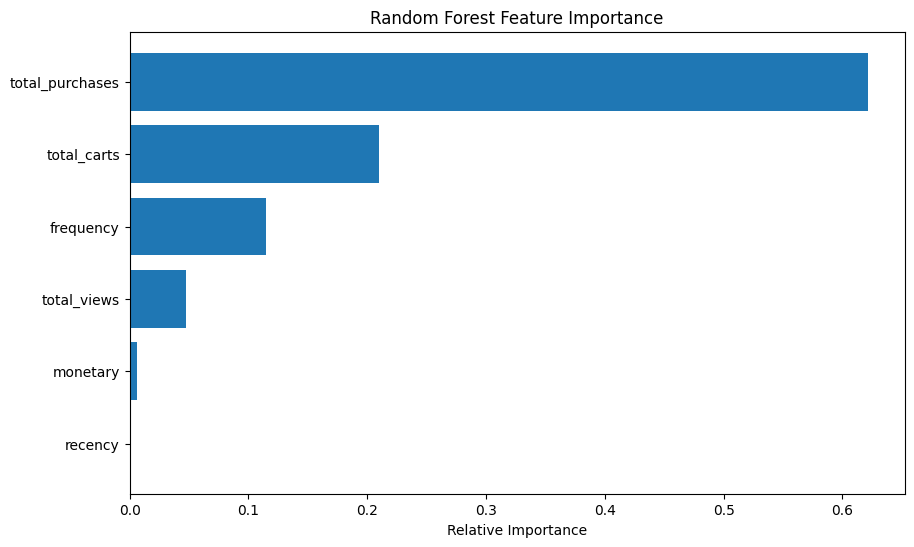

In [ ]:
# Get feature importance
importances = rf_model.feature_importances_

# Sort feature importance
indices = np.argsort(importances)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importance')
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
import xgboost as xgb

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train, y_train)
# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)


In [ ]:
# Evaluate model performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb}")
print(f"AUC: {auc_xgb}")
print(f"Classification Report:\n{classification_rep_xgb}")
print(f"Confusion Matrix:\n{conf_matrix_xgb}")


Accuracy: 1.0
AUC: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    115885
           1       1.00      1.00      1.00      6300

    accuracy                           1.00    122185
   macro avg       1.00      1.00      1.00    122185
weighted avg       1.00      1.00      1.00    122185

Confusion Matrix:
[[115885      0]
 [     0   6300]]


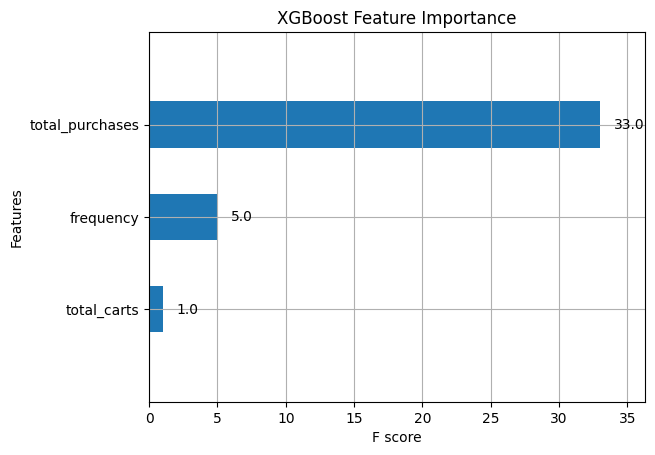

In [ ]:
# Plot feature importance using XGBoost
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, height=0.5)
plt.title("XGBoost Feature Importance")
plt.show()


In [ ]:
# Compare Random Forest and XGBoost performance
print(f"Random Forest Accuracy: {accuracy}")
print(f"XGBoost Accuracy: {accuracy_xgb}")

print(f"Random Forest AUC: {auc}")
print(f"XGBoost AUC: {auc_xgb}")


Random Forest Accuracy: 1.0
XGBoost Accuracy: 1.0
Random Forest AUC: 1.0
XGBoost AUC: 1.0


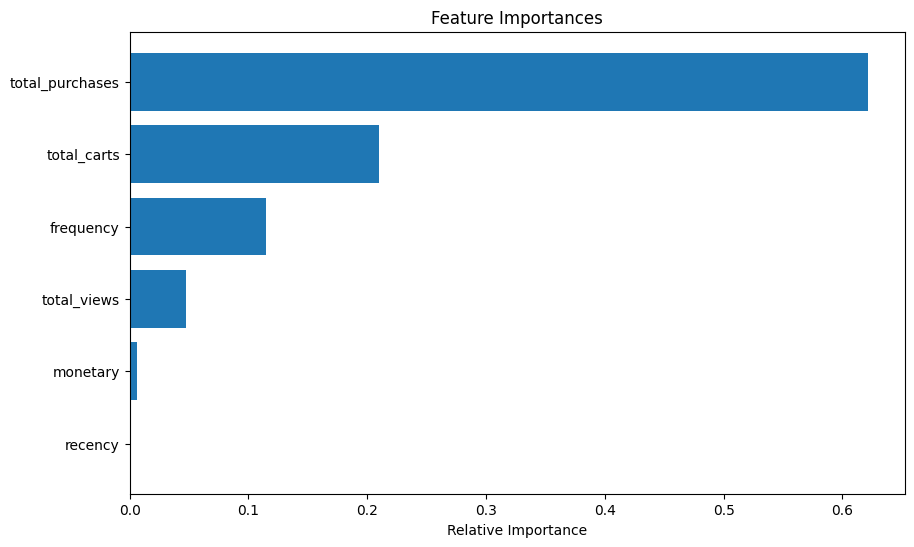

In [ ]:

# Plot feature importance for Random Forest
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.xlabel('Relative Importance')
plt.show()


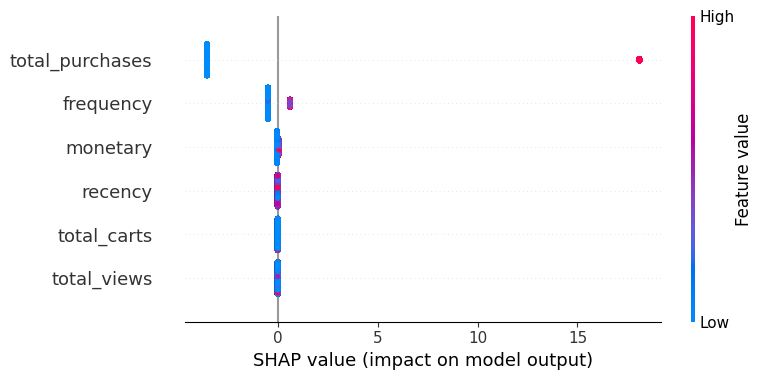

In [ ]:

import shap
import xgboost as xgb

# Train your model (assuming X_train and y_train are defined)
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values.values, X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import make_scorer, roc_auc_score

# Define AUC scorer
auc_scorer = make_scorer(roc_auc_score)

# Cross-validation using 5 folds and AUC scoring
cv_auc_results_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring=auc_scorer)

# Print cross-validation AUC results
print(f"Random Forest cross-validation AUC scores: {cv_auc_results_rf}")
print(f"Mean Random Forest cross-validation AUC: {np.mean(cv_auc_results_rf)}")

# Define the Random Forest model with simple hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=3,       # Maximum depth of trees
    random_state=42
)

# Cross-validation using 5 folds
cv_results_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print(f"Random Forest cross-validation accuracy scores: {cv_results_rf}")
print(f"Mean Random Forest cross-validation accuracy: {np.mean(cv_results_rf)}")

# Alternatively, use AUC as the scoring metric
cv_auc_results_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring=auc_scorer)

# Print cross-validation AUC results
print(f"Random Forest cross-validation AUC scores: {cv_auc_results_rf}")
print(f"Mean Random Forest cross-validation AUC: {np.mean(cv_auc_results_rf)}")


Random Forest cross-validation AUC scores: [1. 1. 1. 1. 1.]
Mean Random Forest cross-validation AUC: 1.0
Random Forest cross-validation accuracy scores: [1. 1. 1. 1. 1.]
Mean Random Forest cross-validation accuracy: 1.0
Random Forest cross-validation AUC scores: [1. 1. 1. 1. 1.]
Mean Random Forest cross-validation AUC: 1.0


In [ ]:
# checking overfitting condition or any issues
# Evaluate model on training set
rf_model.fit(X_train, y_train)
train_accuracy = rf_model.score(X_train, y_train)
train_auc = roc_auc_score(y_train, rf_model.predict_proba(X_train)[:, 1])

# Evaluate model on test set
test_accuracy = rf_model.score(X_test, y_test)
test_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Training AUC: {train_auc}")
print(f"Test AUC: {test_auc}")


Training Accuracy: 1.0
Test Accuracy: 1.0
Training AUC: 1.0000000000000002
Test AUC: 0.9999999999999999


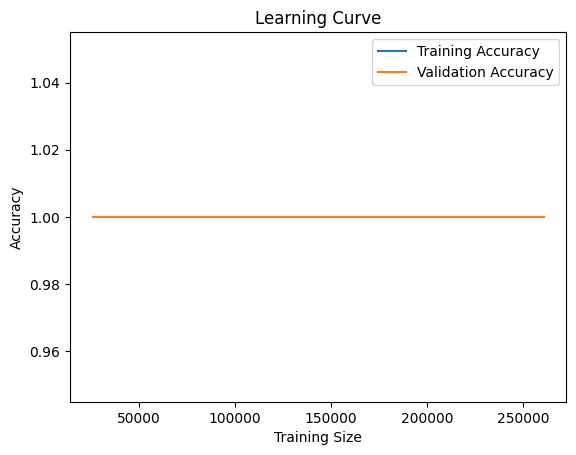

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Learning curve
train_sizes, train_scores, validation_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1
)

# Calculate mean and standard deviation for train and validation scores
train_mean = train_scores.mean(axis=1)
validation_mean = validation_scores.mean(axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, validation_mean, label='Validation Accuracy')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()


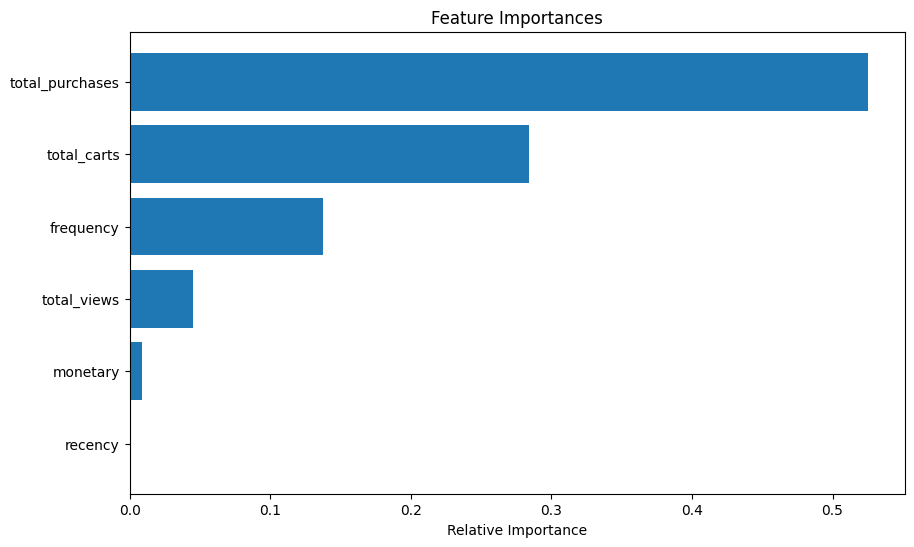

In [ ]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), np.array(X_train.columns)[indices])
plt.xlabel('Relative Importance')
plt.show()


In [ ]:
#from tensorflow.keras.models import load_model

# Load the model back
#loaded_model = load_model('keras_model.h5')

# Use the model to make predictions
#predictions = loaded_model.predict(X_test)


In [ ]:
import pickle

# Save the trained XGBoost model
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)


In [ ]:
# Load the model back from file
with open('xgboost_model.pkl', 'rb') as file:
    loaded_xgb_model = pickle.load(file)

# Use the loaded model to make predictions
predictions = loaded_xgb_model.predict(X_test)
